# Titanic - CatBoost Only (Fold-Safe版)

## 改善点:
- Fold-Safe前処理: 各Foldで統計量を再計算
- StratifiedKFold: クラスバランス維持
- CatBoost最適化: 文字列カテゴリ使用
- 学習曲線可視化
- 詳細メトリクス表示

## 1. セットアップ

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import string
warnings.filterwarnings("ignore")

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, roc_curve
from catboost import CatBoostClassifier, Pool
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

RANDOM_STATE = 42
N_FOLDS = 5
np.random.seed(RANDOM_STATE)
optuna.logging.set_verbosity(optuna.logging.WARNING)

print("ライブラリのインポート完了")

ライブラリのインポート完了


## 2. データ読み込み

In [2]:
df_train = pd.read_csv("../input/train.csv")
df_test = pd.read_csv("../input/test.csv")

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
print(f"\nTarget distribution:")
print(df_train["Perished"].value_counts(normalize=True))

Train shape: (891, 12)
Test shape: (418, 11)

Target distribution:
Perished
1    0.616162
0    0.383838
Name: proportion, dtype: float64


## 3. 基本特徴量作成

In [3]:
def extract_surname(data):
    """名前から姓を抽出"""
    families = []
    for i in range(len(data)):
        name = data.iloc[i]
        if "(" in name:
            name_no_bracket = name.split("(")[0]
        else:
            name_no_bracket = name
        family = name_no_bracket.split(",")[0]
        for c in string.punctuation:
            family = family.replace(c, "").strip()
        families.append(family)
    return families


def create_base_features(df):
    """Fold-independentな基本特徴量のみ作成"""
    data = df.copy()
    
    # 1. Title抽出
    data["Title_raw"] = data["Name"].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    
    # 2. Is_Married（Title統合前に判定）
    data["Is_Married"] = (data["Title_raw"] == "Mrs").astype(int)
    
    # 3. Title正規化
    data["Title"] = data["Title_raw"].replace(
        ["Miss", "Mrs", "Ms", "Mlle", "Lady", "Mme", "the Countess", "Dona"], "Miss/Mrs/Ms"
    )
    data["Title"] = data["Title"].replace(
        ["Dr", "Col", "Major", "Jonkheer", "Capt", "Sir", "Don", "Rev"], "Dr/Military/Noble/Clergy"
    )
    
    # 4. Family（姓）
    data["Family"] = extract_surname(data["Name"])
    
    # 5. Family_Size
    data["Family_Size"] = data["SibSp"] + data["Parch"] + 1
    
    # 6. Family_Size_Grouped
    family_map = {
        1: "Alone",
        2: "Small", 3: "Small", 4: "Small",
        5: "Medium", 6: "Medium",
        7: "Large", 8: "Large", 11: "Large"
    }
    data["Family_Size_Grouped"] = data["Family_Size"].map(family_map)
    
    # 7. Deck
    data["Deck"] = data["Cabin"].apply(lambda s: s[0] if pd.notnull(s) else "M")
    data["Deck"] = data["Deck"].replace(["A", "B", "C"], "ABC")
    data["Deck"] = data["Deck"].replace(["D", "E"], "DE")
    data["Deck"] = data["Deck"].replace(["F", "G"], "FG")
    data["Deck"] = data["Deck"].replace(["T"], "M")
    
    # 8. Embarked補完
    data["Embarked"] = data["Embarked"].fillna("S")
    
    # 9. Sex x Pclass 交互作用
    data["Sex_Pclass"] = data["Sex"] + "_" + data["Pclass"].astype(str)
    
    # Age, Fareは元のまま保持
    data["Age"] = pd.to_numeric(data["Age"], errors="coerce")
    
    return data


# 基本特徴量作成
train_base = create_base_features(df_train)
test_base = create_base_features(df_test)

print(f"✅ 基本特徴量作成完了")
print(f"Train shape: {train_base.shape}")
print(f"Test shape: {test_base.shape}")
print(f"Is_Married有効数: {train_base['Is_Married'].sum()}件")

✅ 基本特徴量作成完了
Train shape: (891, 20)
Test shape: (418, 19)
Is_Married有効数: 125件


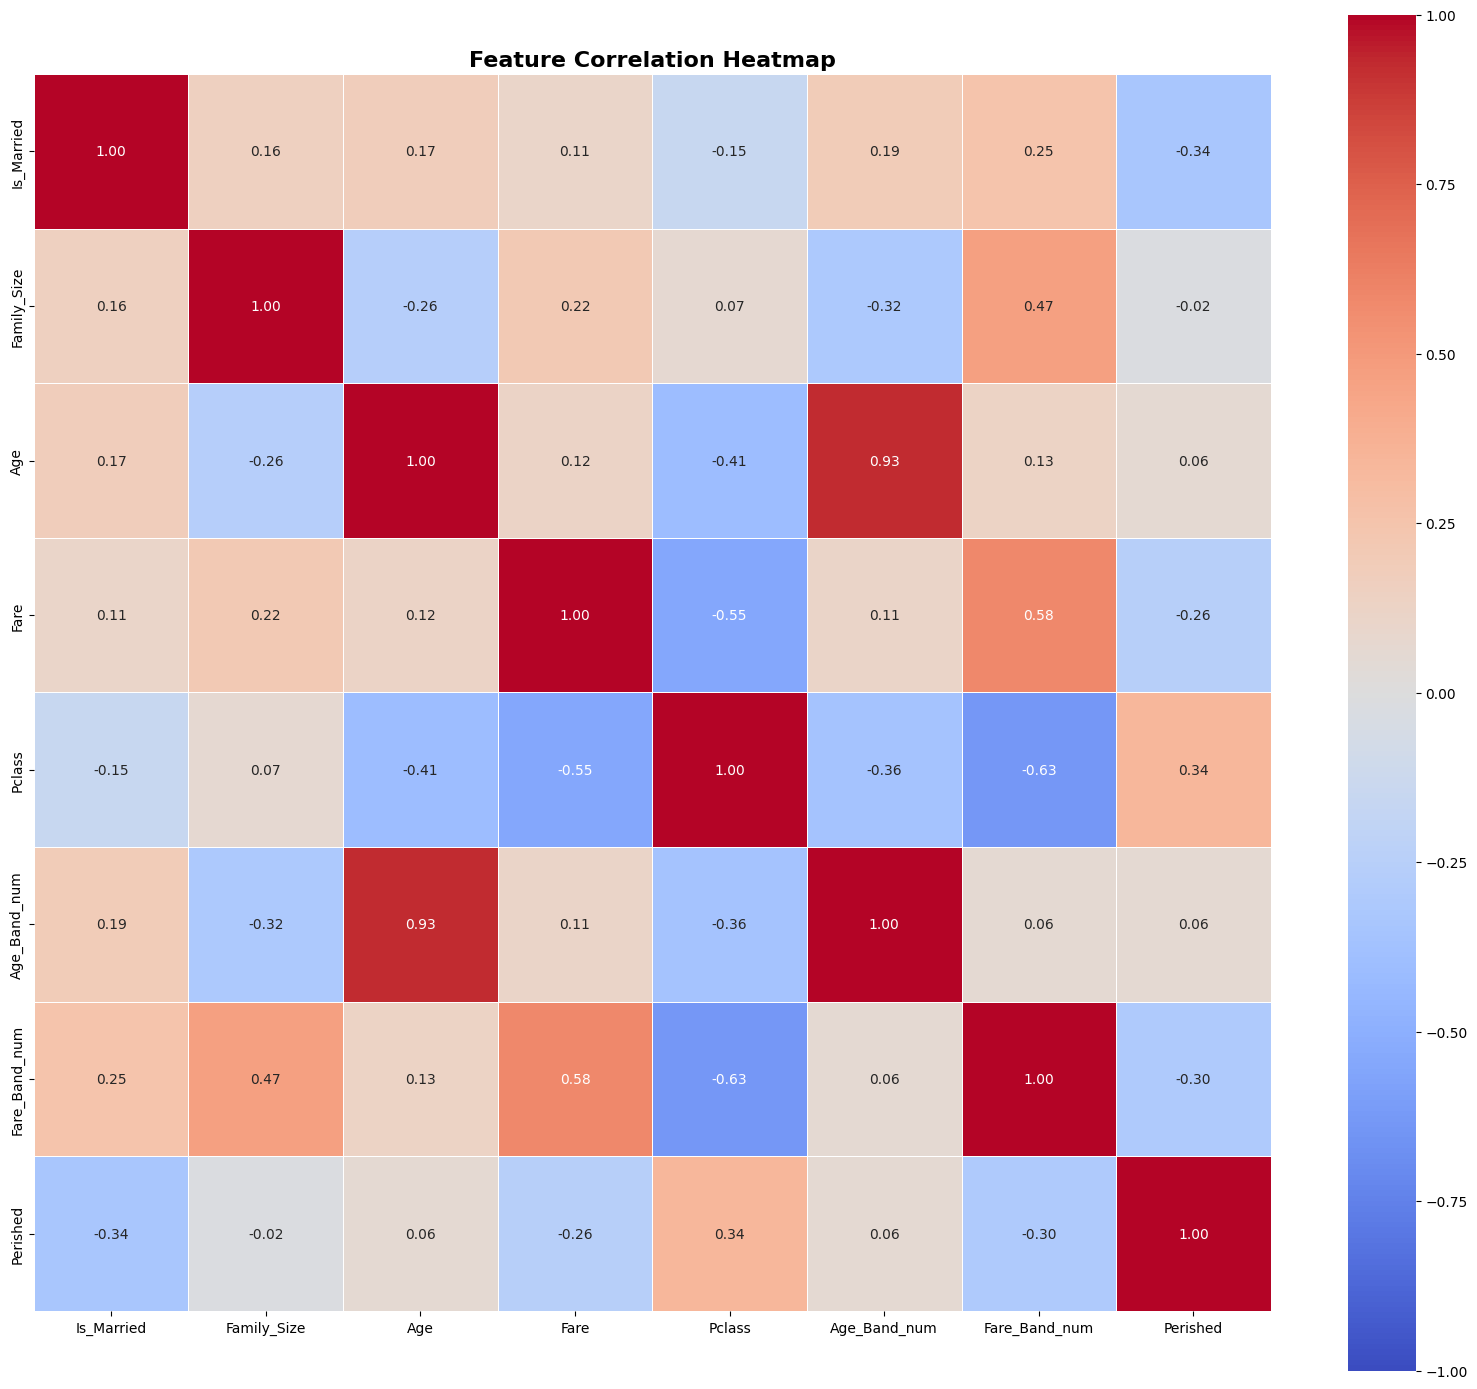


相関ヒートマップを保存: ../output/correlation_heatmap.png

Top correlations with Perished:
Pclass           0.338481
Age              0.059579
Age_Band_num     0.055675
Family_Size     -0.016639
Fare            -0.257307
Fare_Band_num   -0.299357
Is_Married      -0.339040
Name: Perished, dtype: float64


In [4]:
# 相関ヒートマップ用にサンプルデータを準備
# 簡易的に全データで統計量を計算（可視化目的のみ）
sample_train = train_base.copy()
sample_test = test_base.copy()

# Age補完
age_median = sample_train.groupby(["Sex", "Pclass"])["Age"].median()
for pclass in [1, 2, 3]:
    for sex in ["male", "female"]:
        mask_train = (sample_train["Age"].isnull()) & (sample_train["Pclass"] == pclass) & (sample_train["Sex"] == sex)
        mask_test = (sample_test["Age"].isnull()) & (sample_test["Pclass"] == pclass) & (sample_test["Sex"] == sex)
        if mask_train.any():
            sample_train.loc[mask_train, "Age"] = age_median.loc[(sex, pclass)]
        if mask_test.any():
            sample_test.loc[mask_test, "Age"] = age_median.loc[(sex, pclass)]

# Age_Band
sample_train["Age_Band_num"] = pd.cut(sample_train["Age"], bins=[0, 12, 18, 30, 50, 80], labels=[0, 1, 2, 3, 4])
sample_test["Age_Band_num"] = pd.cut(sample_test["Age"], bins=[0, 12, 18, 30, 50, 80], labels=[0, 1, 2, 3, 4])

# Fare補完とバンド化
fare_median = sample_train["Fare"].median()
sample_train["Fare"] = sample_train["Fare"].fillna(fare_median)
sample_test["Fare"] = sample_test["Fare"].fillna(fare_median)

fare_quantiles = sample_train["Fare"].quantile([0.25, 0.5, 0.75]).values
sample_train["Fare_Band_num"] = pd.cut(
    sample_train["Fare"],
    bins=[-np.inf] + fare_quantiles.tolist() + [np.inf],
    labels=[0, 1, 2, 3]
)
sample_test["Fare_Band_num"] = pd.cut(
    sample_test["Fare"],
    bins=[-np.inf] + fare_quantiles.tolist() + [np.inf],
    labels=[0, 1, 2, 3]
)

# 数値特徴量のみ選択（相関ヒートマップ用）
numeric_features = ["Is_Married", "Family_Size", "Age", "Fare", "Pclass", "Age_Band_num", "Fare_Band_num"]
X_corr = sample_train[numeric_features].copy()
X_corr["Perished"] = sample_train["Perished"]

# 相関ヒートマップ
corr = X_corr.corr()

plt.figure(figsize=(16,14))
sns.heatmap(
    corr,
    annot=True,          # 数値を表示
    fmt=".2f",           # 小数点2桁
    cmap="coolwarm",
    square=True,
    linewidths=0.5,      # 枠線
    cbar=True,           # カラーバー
    vmin=-1,             # 最小値
    vmax=1               # 最大値
)
plt.title("Feature Correlation Heatmap", fontsize=16, fontweight='bold')
plt.tight_layout()
os.makedirs("../output", exist_ok=True)
plt.savefig('../output/correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n相関ヒートマップを保存: ../output/correlation_heatmap.png")
print(f"\nTop correlations with Perished:")
perished_corr = corr["Perished"].drop("Perished").sort_values(ascending=False)
print(perished_corr)

In [5]:
def objective(trial, train_base, n_folds=5):
    """
    Optuna目的関数: CatBoostのハイパーパラメータを最適化
    
    Args:
        trial: Optunaのトライアルオブジェクト
        train_base: 学習データ
        n_folds: CVのFold数（チューニング時は少なめに設定）
    
    Returns:
        平均検証スコア（ROC-AUC）
    """
    # ハイパーパラメータの探索空間
    params = {
        "iterations": trial.suggest_int("iterations", 500, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "random_strength": trial.suggest_float("random_strength", 0.5, 2.0),
        "rsm": trial.suggest_float("rsm", 0.5, 1.0),
        "loss_function": "Logloss",
        "eval_metric": "Logloss",
        "random_state": RANDOM_STATE,
        "verbose": 0
    }
    
    # StratifiedKFold
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=RANDOM_STATE)
    y = train_base["Perished"]
    
    # 各FoldのROC-AUCスコアを保存
    valid_scores = []
    
    cat_features = ["Embarked", "Title", "Family_Size_Grouped", "Age_Band", "Fare_Band", "Sex_Pclass"]
    
    for fold, (train_idx, valid_idx) in enumerate(skf.split(train_base, y)):
        # データコピー
        train_fold = train_base.iloc[train_idx].copy()
        valid_fold = train_base.iloc[valid_idx].copy()
        test_fold = test_base.copy()
        
        # Fold-Safe特徴量作成
        train_fold, valid_fold, test_fold = apply_fold_safe_features(
            train_fold, valid_fold, test_fold
        )
        
        # データ準備
        X_train, y_train, X_valid, y_valid, _ = prepare_fold_data(
            train_fold, valid_fold, test_fold, cat_features
        )
        
        # CatBoost学習
        train_pool = Pool(X_train, y_train, cat_features=cat_features)
        valid_pool = Pool(X_valid, y_valid, cat_features=cat_features)
        
        model = CatBoostClassifier(**params)
        model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=0)
        
        # 検証スコア
        valid_proba = model.predict_proba(valid_pool)[:, 1]
        valid_roc_auc = roc_auc_score(y_valid, valid_proba)
        valid_scores.append(valid_roc_auc)
    
    # 平均ROC-AUCを返す
    mean_roc_auc = np.mean(valid_scores)
    return mean_roc_auc


print("Optuna目的関数定義完了")

Optuna目的関数定義完了


In [6]:
def apply_fold_safe_features(train_data, valid_data, test_data):
    """
    Fold-Safe: 各Foldのtrain setのみで統計量を計算
    
    重要: train_dataはすでにtrain部分のみを含む想定
    データリaーク防止のため、trainとvalidは事前に分離すること
    """
    # 統計量計算用にtrain部分を使用
    train_fold = train_data.copy()
    
    # 1. Age補完（Fold trainのみの中央値）
    fold_age_median = train_fold.groupby(["Sex", "Pclass"])["Age"].median()
    
    # train/valid/testそれぞれにAge補完を適用
    for data in [train_data, valid_data, test_data]:
        for pclass in [1, 2, 3]:
            for sex in ["male", "female"]:
                mask = (data["Age"].isnull()) & (data["Pclass"] == pclass) & (data["Sex"] == sex)
                if mask.any():
                    data.loc[mask, "Age"] = fold_age_median.loc[(sex, pclass)]
    
    # Age_Band
    for data in [train_data, valid_data, test_data]:
        data["Age_Band"] = pd.cut(data["Age"], bins=[0, 12, 18, 30, 50, 80], 
                                   labels=["Child", "Teen", "Adult", "Middle", "Senior"])
    
    # 2. Fare補完（Fold trainのみの統計量）
    fold_fare_median = train_fold["Fare"].median()
    fold_fare_quantiles = train_fold["Fare"].quantile([0.25, 0.5, 0.75]).values
    
    for data in [train_data, valid_data, test_data]:
        data["Fare"] = data["Fare"].fillna(fold_fare_median)
        data["Fare_Band"] = pd.cut(
            data["Fare"],
            bins=[-np.inf] + fold_fare_quantiles.tolist() + [np.inf],
            labels=["Low", "Medium", "High", "Very_High"]
        )
    
    return train_data, valid_data, test_data


def prepare_fold_data(train_data, valid_data, test_data, cat_features):
    """Fold用のデータを準備（CatBoost用）"""
    feature_cols = [
         "Is_Married",
        "Embarked", "Title", "Family_Size_Grouped", 
        "Age_Band", "Fare_Band", "Sex_Pclass",
        #  "Pclass",
        # "Age",
        # "Fare",

    ]
    
    # データ抽出
    X_train = train_data[feature_cols].copy()
    y_train = train_data["Perished"].copy()
    X_valid = valid_data[feature_cols].copy()
    y_valid = valid_data["Perished"].copy()
    X_test = test_data[feature_cols].copy()
    
    return X_train, y_train, X_valid, y_valid, X_test


print("Fold-Safe関数定義完了")

Fold-Safe関数定義完了


In [7]:
# Optunaでハイパーパラメータチューニング
TUNE_HYPERPARAMETERS = True  # Falseにするとチューニングをスキップ
N_TRIALS = 50  # チューニングの試行回数

if TUNE_HYPERPARAMETERS:
    print("="*60)
    print("Optuna ハイパーパラメータチューニング開始")
    print("="*60)
    print(f"試行回数: {N_TRIALS}")
    print(f"CV Folds: 5 (チューニング時は高速化のため少なめ)")
    print("="*60)
    
    # Optunaスタディの作成
    study = optuna.create_study(
        direction="maximize",  # ROC-AUCを最大化
        sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE)
    )
    
    # 最適化実行
    study.optimize(
        lambda trial: objective(trial, train_base, n_folds=5),
        n_trials=N_TRIALS,
        show_progress_bar=True
    )
    
    # 最適なパラメータを取得
    best_params_catboost = study.best_params
    best_params_catboost.update({
        "loss_function": "Logloss",
        "eval_metric": "Logloss",
        "random_state": RANDOM_STATE,
        "verbose": 0
    })
    
    print("\n" + "="*60)
    print("チューニング完了")
    print("="*60)
    print(f"最適なROC-AUC: {study.best_value:.4f}")
    print(f"\n最適なパラメータ:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")
    print("="*60)
    
else:
    # デフォルトパラメータを使用
    best_params_catboost = {
        "iterations": 1000,
        "learning_rate": 0.03,
        "depth": 7,
        "l2_leaf_reg": 6.0,
        "bagging_temperature": 0.5,
        "random_strength": 1.0,
        "rsm": 0.9,
        "loss_function": "Logloss",
        "eval_metric": "Logloss",
        "random_state": RANDOM_STATE,
        "verbose": 0
    }
    print("デフォルトパラメータを使用します")
    print(best_params_catboost)

Optuna ハイパーパラメータチューニング開始
試行回数: 50
CV Folds: 5 (チューニング時は高速化のため少なめ)


  0%|          | 0/50 [00:00<?, ?it/s]


チューニング完了
最適なROC-AUC: 0.8904

最適なパラメータ:
  iterations: 965
  learning_rate: 0.03422874671761938
  depth: 7
  l2_leaf_reg: 8.272594310024477
  bagging_temperature: 0.9960169893612132
  random_strength: 1.6561396431447641
  rsm: 0.6639538167911315


## 4. CatBoostハイパーパラメータ

In [8]:
# best_params_catboost = {
#     "iterations": 1000,
#     "learning_rate": 0.03,
#     "depth": 7,
#     "l2_leaf_reg": 6.0,
#     "bagging_temperature": 0.5,
#     "random_strength": 1.0,
#     "rsm": 0.9,
#     "loss_function": "Logloss",
#     "eval_metric": "Logloss",
#     "random_state": RANDOM_STATE,
#     "verbose": 0
# }

# print("ハイパーパラメータ設定完了")

## 5. Fold-Safe前処理関数

In [9]:
def apply_fold_safe_features(train_data, valid_data, test_data):
    """
    Fold-Safe: 各Foldのtrain setのみで統計量を計算
    
    重要: train_dataはすでにtrain部分のみを含む想定
    データリーク防止のため、trainとvalidは事前に分離すること
    """
    # 統計量計算用にtrain部分を使用
    train_fold = train_data.copy()
    
    # 1. Age補完（Fold trainのみの中央値）
    fold_age_median = train_fold.groupby(["Sex", "Pclass"])["Age"].median()
    
    # train/valid/testそれぞれにAge補完を適用
    for data in [train_data, valid_data, test_data]:
        for pclass in [1, 2, 3]:
            for sex in ["male", "female"]:
                mask = (data["Age"].isnull()) & (data["Pclass"] == pclass) & (data["Sex"] == sex)
                if mask.any():
                    data.loc[mask, "Age"] = fold_age_median.loc[(sex, pclass)]
    
    # Age_Band
    for data in [train_data, valid_data, test_data]:
        data["Age_Band"] = pd.cut(data["Age"], bins=[0, 12, 18, 30, 50, 80], 
                                   labels=["Child", "Teen", "Adult", "Middle", "Senior"])
    
    # 2. Fare補完（Fold trainのみの統計量）
    fold_fare_median = train_fold["Fare"].median()
    fold_fare_quantiles = train_fold["Fare"].quantile([0.25, 0.5, 0.75]).values
    
    for data in [train_data, valid_data, test_data]:
        data["Fare"] = data["Fare"].fillna(fold_fare_median)
        data["Fare_Band"] = pd.cut(
            data["Fare"],
            bins=[-np.inf] + fold_fare_quantiles.tolist() + [np.inf],
            labels=["Low", "Medium", "High", "Very_High"]
        )
    
    return train_data, valid_data, test_data


def prepare_fold_data(train_data, valid_data, test_data, cat_features):
    """Fold用のデータを準備（CatBoost用）"""
    feature_cols = [
         "Is_Married",
        "Embarked", "Title", "Family_Size_Grouped", 
        "Age_Band", "Fare_Band", "Sex_Pclass",
        #  "Pclass",
        # "Age",
        # "Fare",

    ]
    
    # データ抽出
    X_train = train_data[feature_cols].copy()
    y_train = train_data["Perished"].copy()
    X_valid = valid_data[feature_cols].copy()
    y_valid = valid_data["Perished"].copy()
    X_test = test_data[feature_cols].copy()
    
    return X_train, y_train, X_valid, y_valid, X_test


print("Fold-Safe関数定義完了")



Fold-Safe関数定義完了


## 6. CatBoost学習

In [10]:
def train_catboost_fold_safe(train_base, test_base, n_folds=10):
    """StratifiedKFold + Fold-Safe前処理でCatBoost学習"""
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=RANDOM_STATE)
    
    y = train_base["Perished"]
    
    # OOF予測保存用
    oof_proba = np.zeros(len(train_base))
    test_proba = np.zeros((len(test_base), n_folds))
    
    models = []
    train_scores = []
    valid_scores = []
    
    # 学習曲線保存用
    learning_curves = []
    
    # メトリクス保存用
    metrics_history = {
        "train_acc": [], "valid_acc": [],
        "train_logloss": [], "valid_logloss": [],
        "valid_roc_auc": []
    }

    cat_features = ["Embarked", "Title", "Family_Size_Grouped", "Age_Band", "Fare_Band", "Sex_Pclass"]
    print("="*60)
    print("CatBoost Fold-Safe Training")
    print("="*60)
    
    for fold, (train_idx, valid_idx) in enumerate(skf.split(train_base, y)):
        print(f"\n{'='*60}")
        print(f"Fold {fold + 1}/{n_folds}")
        print(f"  Train: {len(train_idx)} samples, Valid: {len(valid_idx)} samples")
        
        # クラス分布確認
        train_dist = y.iloc[train_idx].value_counts(normalize=True)
        valid_dist = y.iloc[valid_idx].value_counts(normalize=True)
        print(f"  Train distribution: {train_dist[1]:.3f} Perished")
        print(f"  Valid distribution: {valid_dist[1]:.3f} Perished")
        print(f"{'='*60}")

        
        # データコピー（重要：train/validを分離してからコピー）
        train_fold = train_base.iloc[train_idx].copy()
        valid_fold = train_base.iloc[valid_idx].copy()
        test_fold = test_base.copy()
        
        # Fold-Safe特徴量作成
        train_fold, valid_fold, test_fold = apply_fold_safe_features(
            train_fold, valid_fold, test_fold
        )
        
        # データ準備
        X_train, y_train, X_valid, y_valid, X_test = prepare_fold_data(
            train_fold, valid_fold, test_fold, cat_features
        )
        
        # CatBoost学習
        print("\nTraining CatBoost...")
        train_pool = Pool(X_train, y_train, cat_features=cat_features)
        valid_pool = Pool(X_valid, y_valid, cat_features=cat_features)
        test_pool = Pool(X_test, cat_features=cat_features)
        
        model = CatBoostClassifier(**best_params_catboost)
        model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=0)
        
        # 学習曲線を取得
        evals_result = model.get_evals_result()
        learning_curves.append(evals_result)
        
        # 予測
        oof_proba[valid_idx] = model.predict_proba(valid_pool)[:, 1]
        test_proba[:, fold] = model.predict_proba(test_pool)[:, 1]
        models.append(model)
        
        # メトリクス計算
        train_proba = model.predict_proba(train_pool)[:, 1]
        valid_proba = model.predict_proba(valid_pool)[:, 1]
        
        train_acc = accuracy_score(y_train, model.predict(train_pool))
        valid_acc = accuracy_score(y_valid, model.predict(valid_pool))
        train_logloss = log_loss(y_train, train_proba)
        valid_logloss = log_loss(y_valid, valid_proba)
        valid_roc_auc = roc_auc_score(y_valid, valid_proba)
        
        train_scores.append(train_acc)
        valid_scores.append(valid_acc)
        
        metrics_history["train_acc"].append(train_acc)
        metrics_history["valid_acc"].append(valid_acc)
        metrics_history["train_logloss"].append(train_logloss)
        metrics_history["valid_logloss"].append(valid_logloss)
        metrics_history["valid_roc_auc"].append(valid_roc_auc)
        
        print(f"  Acc: Train {train_acc:.4f} | Valid {valid_acc:.4f} | Gap {train_acc - valid_acc:.4f}")
        print(f"  Logloss: Train {train_logloss:.4f} | Valid {valid_logloss:.4f}")
        print(f"  ROC-AUC: Valid {valid_roc_auc:.4f}")
    
    # CV結果サマリー
    print(f"\n{'='*60}")
    print("Cross-Validation Results")
    print(f"{'='*60}")

    
    train_mean = np.mean(train_scores)
    train_std = np.std(train_scores)
    valid_mean = np.mean(valid_scores)
    valid_std = np.std(valid_scores)
    gap = train_mean - valid_mean
    
    valid_logloss_mean = np.mean(metrics_history["valid_logloss"])
    valid_roc_auc_mean = np.mean(metrics_history["valid_roc_auc"])
    
    print(f"CatBoost:")
    print(f"  Accuracy: Train {train_mean:.4f} ± {train_std:.4f} | Valid {valid_mean:.4f} ± {valid_std:.4f} | Gap {gap:.4f}")
    print(f"  Logloss:  Valid {valid_logloss_mean:.4f}")
    print(f"  ROC-AUC:  Valid {valid_roc_auc_mean:.4f}")
    
    return {
        "oof_proba": oof_proba,
        "test_proba": test_proba.mean(axis=1),
        "models": models,
        "y": y,
        "learning_curves": learning_curves,
        "metrics_history": metrics_history
    }


# 学習実行
results = train_catboost_fold_safe(train_base, test_base, n_folds=N_FOLDS)

CatBoost Fold-Safe Training

Fold 1/5
  Train: 712 samples, Valid: 179 samples
  Train distribution: 0.617 Perished
  Valid distribution: 0.615 Perished

Training CatBoost...
  Acc: Train 0.8596 | Valid 0.8156 | Gap 0.0439
  Logloss: Train 0.3561 | Valid 0.3891
  ROC-AUC: Valid 0.9053

Fold 2/5
  Train: 713 samples, Valid: 178 samples
  Train distribution: 0.616 Perished
  Valid distribution: 0.618 Perished

Training CatBoost...
  Acc: Train 0.8612 | Valid 0.8258 | Gap 0.0353
  Logloss: Train 0.3455 | Valid 0.3729
  ROC-AUC: Valid 0.9045

Fold 3/5
  Train: 713 samples, Valid: 178 samples
  Train distribution: 0.616 Perished
  Valid distribution: 0.618 Perished

Training CatBoost...
  Acc: Train 0.8471 | Valid 0.8315 | Gap 0.0157
  Logloss: Train 0.3687 | Valid 0.4160
  ROC-AUC: Valid 0.8610

Fold 4/5
  Train: 713 samples, Valid: 178 samples
  Train distribution: 0.616 Perished
  Valid distribution: 0.618 Perished

Training CatBoost...
  Acc: Train 0.8513 | Valid 0.8539 | Gap -0.0026
  

## 7. テスト予測と提出

In [11]:
# テスト予測
test_predictions_proba = results["test_proba"]
final_predictions = (test_predictions_proba >= 0.5).astype(int)
output_path = "../output/submission_catboost_only.csv"

submission = pd.DataFrame({
    "PassengerId": test_base["PassengerId"],
    "Perished": final_predictions
})

os.makedirs("../output", exist_ok=True)
submission.to_csv(output_path, index=False)

print(f"\n提出ファイル: {output_path}")
print(f"\n予測分布:")
print(f"  Survived (0): {(final_predictions == 0).sum()} ({(final_predictions == 0).sum() / len(final_predictions) * 100:.1f}%)")
print(f"  Perished (1): {(final_predictions == 1).sum()} ({(final_predictions == 1).sum() / len(final_predictions) * 100:.1f}%)")

print(f"\n最初の10行:")
print(submission.head(10))

print(f"\nCatBoost OOF Accuracy: {accuracy_score(results['y'], (results['oof_proba'] >= 0.5).astype(int)):.4f}")



提出ファイル: ../output/submission_catboost_only.csv

予測分布:
  Survived (0): 143 (34.2%)
  Perished (1): 275 (65.8%)

最初の10行:
   PassengerId  Perished
0          892         1
1          893         1
2          894         1
3          895         1
4          896         1
5          897         1
6          898         0
7          899         1
8          900         0
9          901         1

CatBoost OOF Accuracy: 0.8350


## 8. 学習曲線可視化

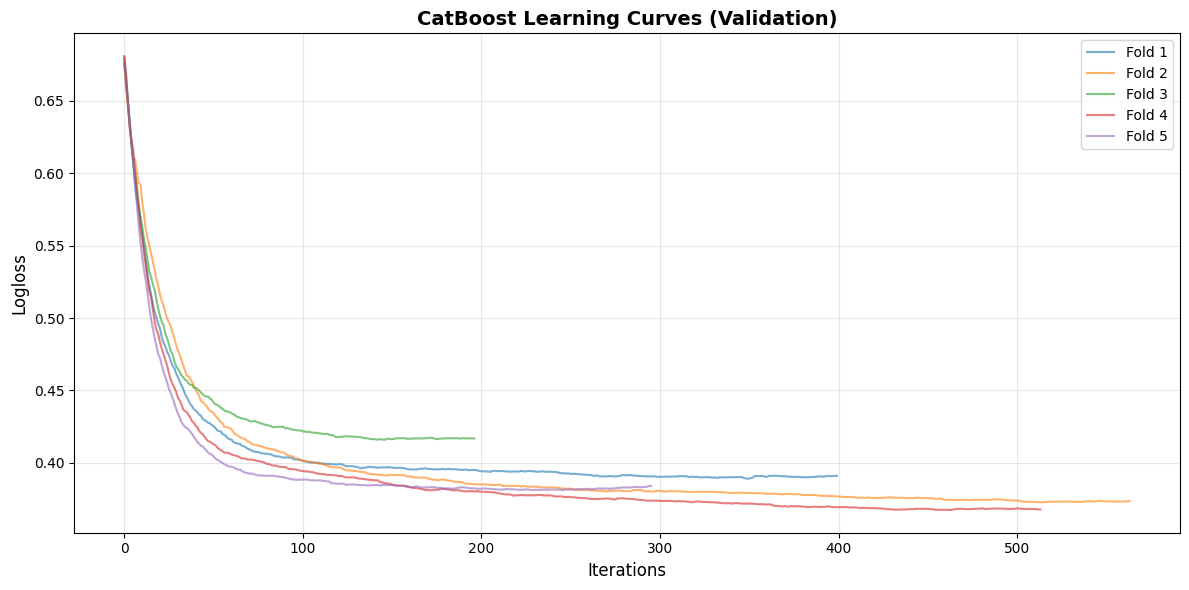

学習曲線を保存: ../output/catboost_learning_curves.png


In [12]:
# 学習曲線の可視化
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

if "learning_curves" in results:
    for fold_idx, evals_result in enumerate(results["learning_curves"]):
        if "validation" in evals_result:
            valid_loss = evals_result["validation"]["Logloss"]
            iterations = range(len(valid_loss))
            ax.plot(iterations, valid_loss, alpha=0.6, label=f"Fold {fold_idx+1}")

ax.set_xlabel("Iterations", fontsize=12)
ax.set_ylabel("Logloss", fontsize=12)
ax.set_title("CatBoost Learning Curves (Validation)", fontweight="bold", fontsize=14)
ax.legend(loc="upper right")
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("../output/catboost_learning_curves.png", dpi=150, bbox_inches="tight")
plt.show()

print("学習曲線を保存: ../output/catboost_learning_curves.png")

## 9. ROC曲線可視化

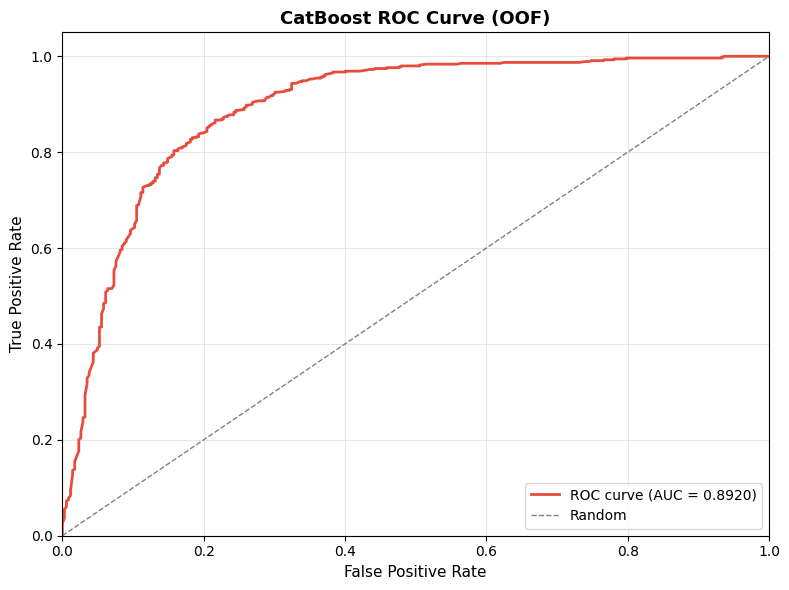

ROC曲線を保存: ../output/catboost_roc_curve.png


In [13]:
# ROC曲線の可視化
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

y = results["y"]
fpr, tpr, _ = roc_curve(y, results["oof_proba"])
roc_auc = roc_auc_score(y, results["oof_proba"])

ax.plot(fpr, tpr, color="#e74c3c", lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
ax.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--", label="Random")

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("False Positive Rate", fontsize=11)
ax.set_ylabel("True Positive Rate", fontsize=11)
ax.set_title("CatBoost ROC Curve (OOF)", fontweight="bold", fontsize=13)
ax.legend(loc="lower right", fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("../output/catboost_roc_curve.png", dpi=150, bbox_inches="tight")
plt.show()

print("ROC曲線を保存: ../output/catboost_roc_curve.png")


特徴量重要度（Feature Importance）

Top 10 重要な特徴量:
            Feature  Importance      Std
         Sex_Pclass   27.437221 4.110528
              Title   20.360162 2.398090
Family_Size_Grouped   14.266013 1.080932
          Fare_Band   14.138150 1.810098
           Age_Band   12.000031 3.395198
           Embarked   10.481771 2.105067
         Is_Married    1.316652 0.425895


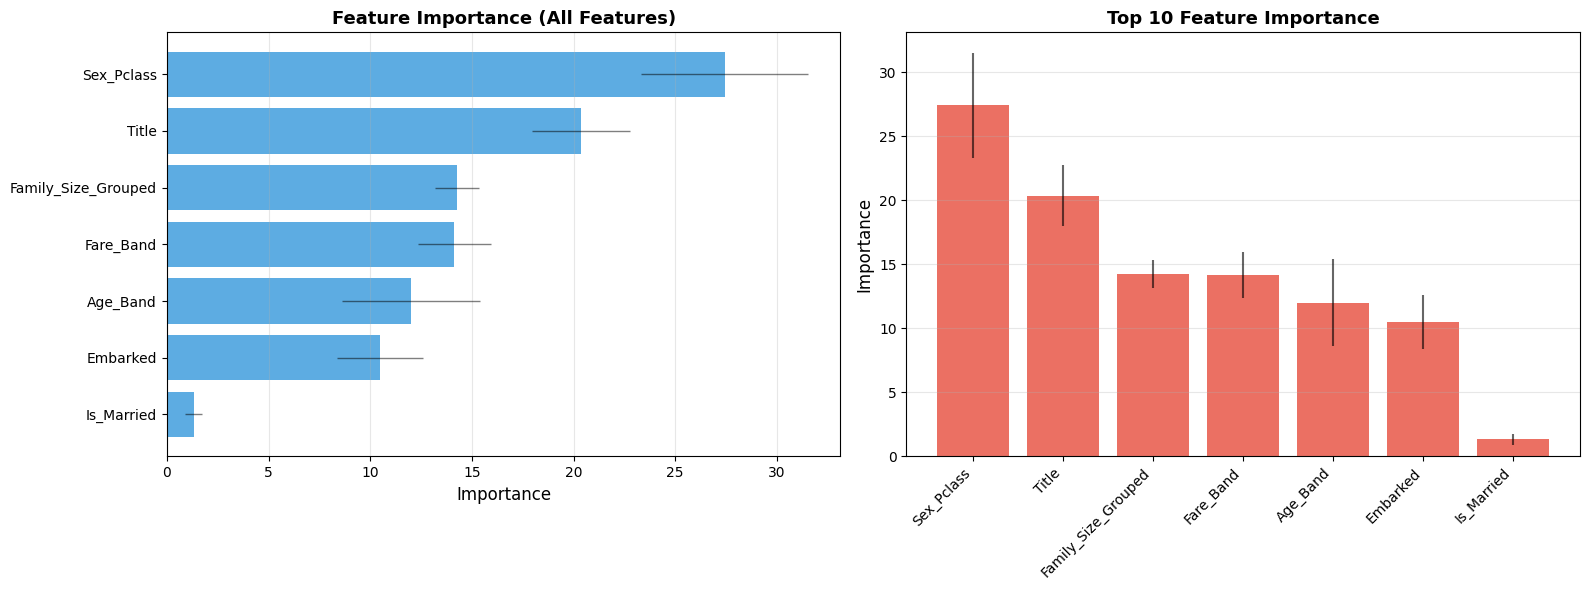


特徴量重要度グラフを保存: ../output/catboost_feature_importance.png
特徴量重要度データを保存: ../output/catboost_feature_importance.csv


In [14]:
# 特徴量重要度の可視化
print("\n" + "="*60)
print("特徴量重要度（Feature Importance）")
print("="*60)

# 各Foldのモデルから特徴量重要度を取得
feature_names = None
all_importances = []

for fold_idx, model in enumerate(results["models"]):
    if feature_names is None:
        feature_names = model.feature_names_
    
    # CatBoostの特徴量重要度（PredictionValuesChange）
    importances = model.get_feature_importance()
    all_importances.append(importances)

# 平均重要度を計算
mean_importances = np.mean(all_importances, axis=0)
std_importances = np.std(all_importances, axis=0)

# DataFrameにまとめる
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": mean_importances,
    "Std": std_importances
}).sort_values("Importance", ascending=False).reset_index(drop=True)

print(f"\nTop 10 重要な特徴量:")
print(importance_df.head(10).to_string(index=False))

# 可視化
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 左側: 横棒グラフ（全特徴量）
ax1 = axes[0]
y_pos = np.arange(len(importance_df))
ax1.barh(y_pos, importance_df["Importance"], xerr=importance_df["Std"], 
         color="#3498db", alpha=0.8, error_kw={"elinewidth": 1, "alpha": 0.5})
ax1.set_yticks(y_pos)
ax1.set_yticklabels(importance_df["Feature"])
ax1.invert_yaxis()
ax1.set_xlabel("Importance", fontsize=12)
ax1.set_title("Feature Importance (All Features)", fontweight="bold", fontsize=13)
ax1.grid(axis="x", alpha=0.3)

# 右側: 縦棒グラフ（Top 10）
ax2 = axes[1]
top10 = importance_df.head(10)
x_pos = np.arange(len(top10))
ax2.bar(x_pos, top10["Importance"], yerr=top10["Std"], 
        color="#e74c3c", alpha=0.8, error_kw={"elinewidth": 1.5, "alpha": 0.6})
ax2.set_xticks(x_pos)
ax2.set_xticklabels(top10["Feature"], rotation=45, ha="right")
ax2.set_ylabel("Importance", fontsize=12)
ax2.set_title("Top 10 Feature Importance", fontweight="bold", fontsize=13)
ax2.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig("../output/catboost_feature_importance.png", dpi=150, bbox_inches="tight")
plt.show()

print("\n特徴量重要度グラフを保存: ../output/catboost_feature_importance.png")

# 特徴量重要度をCSVで保存
importance_df.to_csv("../output/catboost_feature_importance.csv", index=False)
print("特徴量重要度データを保存: ../output/catboost_feature_importance.csv")

## 10. 特徴量重要度（Feature Importance）

## 10. 完了メッセージ

In [15]:
print("\n" + "="*60)
print("すべての処理が完了しました!")
print("="*60)
print(f"\n最終OOFスコア: {accuracy_score(results['y'], (results['oof_proba'] >= 0.5).astype(int)):.4f}")
print("手法: CatBoost単体 (閾値0.5)")

print(f"手法: CatBoost単体 (閾値0.5)")
print(f"\n実装済み最適化:")
print(f"  - Fold-Safe前処理（最重要！）")
print(f"  - StratifiedKFold (クラスバランス維持)")
print(f"  - Is_Married修正")
print(f"  - CatBoost最適化")
print(f"\nFold-Safeによる改善:")
print(f"  - データリーク完全防止")
print(f"  - OOFスコアの信頼性向上")
print(f"  - Testスコアとの乖離減少")
print(f"  - Fold間のブレ安定化")


すべての処理が完了しました!

最終OOFスコア: 0.8350
手法: CatBoost単体 (閾値0.5)
手法: CatBoost単体 (閾値0.5)

実装済み最適化:
  - Fold-Safe前処理（最重要！）
  - StratifiedKFold (クラスバランス維持)
  - Is_Married修正
  - CatBoost最適化

Fold-Safeによる改善:
  - データリーク完全防止
  - OOFスコアの信頼性向上
  - Testスコアとの乖離減少
  - Fold間のブレ安定化



特徴量重要度（Feature Importance）

Top 10 重要な特徴量:
            Feature  Importance      Std
         Sex_Pclass   27.437221 4.110528
              Title   20.360162 2.398090
Family_Size_Grouped   14.266013 1.080932
          Fare_Band   14.138150 1.810098
           Age_Band   12.000031 3.395198
           Embarked   10.481771 2.105067
         Is_Married    1.316652 0.425895


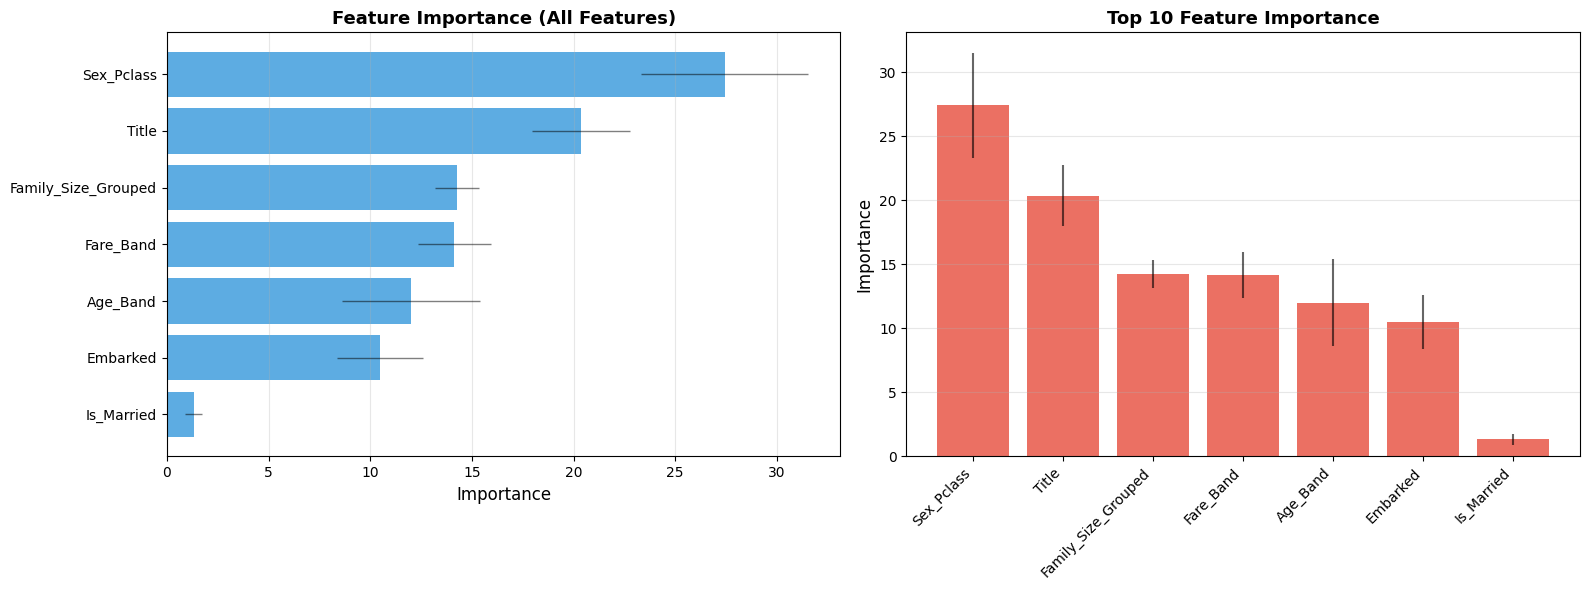


特徴量重要度グラフを保存: ../output/catboost_feature_importance.png
特徴量重要度データを保存: ../output/catboost_feature_importance.csv


In [16]:
# 特徴量重要度の可視化
print("\n" + "="*60)
print("特徴量重要度（Feature Importance）")
print("="*60)

# 各Foldのモデルから特徴量重要度を取得
feature_names = None
all_importances = []

for fold_idx, model in enumerate(results["models"]):
    if feature_names is None:
        feature_names = model.feature_names_
    
    # CatBoostの特徴量重要度（PredictionValuesChange）
    importances = model.get_feature_importance()
    all_importances.append(importances)

# 平均重要度を計算
mean_importances = np.mean(all_importances, axis=0)
std_importances = np.std(all_importances, axis=0)

# DataFrameにまとめる
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": mean_importances,
    "Std": std_importances
}).sort_values("Importance", ascending=False).reset_index(drop=True)

print(f"\nTop 10 重要な特徴量:")
print(importance_df.head(10).to_string(index=False))

# 可視化
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 左側: 横棒グラフ（全特徴量）
ax1 = axes[0]
y_pos = np.arange(len(importance_df))
ax1.barh(y_pos, importance_df["Importance"], xerr=importance_df["Std"], 
         color="#3498db", alpha=0.8, error_kw={"elinewidth": 1, "alpha": 0.5})
ax1.set_yticks(y_pos)
ax1.set_yticklabels(importance_df["Feature"])
ax1.invert_yaxis()
ax1.set_xlabel("Importance", fontsize=12)
ax1.set_title("Feature Importance (All Features)", fontweight="bold", fontsize=13)
ax1.grid(axis="x", alpha=0.3)

# 右側: 縦棒グラフ（Top 10）
ax2 = axes[1]
top10 = importance_df.head(10)
x_pos = np.arange(len(top10))
ax2.bar(x_pos, top10["Importance"], yerr=top10["Std"], 
        color="#e74c3c", alpha=0.8, error_kw={"elinewidth": 1.5, "alpha": 0.6})
ax2.set_xticks(x_pos)
ax2.set_xticklabels(top10["Feature"], rotation=45, ha="right")
ax2.set_ylabel("Importance", fontsize=12)
ax2.set_title("Top 10 Feature Importance", fontweight="bold", fontsize=13)
ax2.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig("../output/catboost_feature_importance.png", dpi=150, bbox_inches="tight")
plt.show()

print("\n特徴量重要度グラフを保存: ../output/catboost_feature_importance.png")

# 特徴量重要度をCSVで保存
importance_df.to_csv("../output/catboost_feature_importance.csv", index=False)
print("特徴量重要度データを保存: ../output/catboost_feature_importance.csv")